<a href="https://colab.research.google.com/github/viswabhaskar1123/Epicsproject-2ndyear-/blob/main/epics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset

In [3]:
# Load BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
emotions = load_dataset('stanfordnlp/sst2')


In [5]:
# Tokenize function for mapping
def tokenize(batch):
    return tokenizer(batch["sentence"], padding=True, truncation=True)

In [6]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)


Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [7]:
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])


In [8]:
BATCH_SIZE = 64
train_dataset = torch.utils.data.DataLoader(emotions_encoded['train'], batch_size=BATCH_SIZE, shuffle=True)
eval_dataset = torch.utils.data.DataLoader(emotions_encoded['validation'], batch_size=BATCH_SIZE)

In [9]:
class BERTForClassification(nn.Module):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.attention_layer = nn.Linear(self.bert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output
        logits = self.fc(pooled_output)

        # Calculate attention weights
        attention_scores = self.attention_layer(outputs.last_hidden_state).squeeze(-1)
        attention_weights = self.sigmoid(attention_scores)

        return logits, attention_weights

In [10]:
# Initialize the classifier
classifier = BERTForClassification(bert_model, num_classes=2)

In [11]:
# Check if CUDA is available and move the model and classifier to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier.to(device)

BERTForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [12]:

# Define optimizer and loss function
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()


In [13]:
attention_weight_changes=[]

In [15]:
# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    classifier.train()
    total_correct_train = 0
    total_samples_train = 0

    for batch in train_dataset:
        batch = {k: v.to(device) for k, v in batch.items()}
        # Move batch to the device
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        targets = batch["label"]

        # Forward pass
        optimizer.zero_grad()
        logits, attentions = classifier(input_ids, attention_mask, None)
        loss = criterion(logits, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Collect attention weights
        for attention in attentions:
            attention_weight_changes.append(attention.detach().cpu().numpy())

        # Calculate accuracy
        _, predicted = torch.max(logits, 1)
        total_samples_train += targets.size(0)
        total_correct_train += (predicted == targets).sum().item()

    # Calculate accuracy after each epoch
    accuracy_train = total_correct_train / total_samples_train
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {accuracy_train:.4f}')


Epoch [1/3], Train Accuracy: 0.9123
Epoch [2/3], Train Accuracy: 0.9553
Epoch [3/3], Train Accuracy: 0.9680


In [19]:
# Evaluation
classifier.eval()
total_correct = 0
total_samples = 0
predicted_labels = []
true_labels = []
with torch.no_grad():
    for batch in eval_dataset:
        # Move batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Unpack the batch
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        token_type_ids = batch['token_type_ids']
        targets = batch['label']

        # Forward pass
        logits, _ = classifier(input_ids, attention_mask, token_type_ids)
        _, predicted = torch.max(logits, 1)
        total_samples += targets.size(0)
        total_correct += (predicted == targets).sum().item()
        # Collect predicted and true labels for F1 score
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())

In [17]:
accuracy = total_correct / total_samples
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9208715596330275


In [20]:
from sklearn.metrics import f1_score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print("F1 Score:", f1)

F1 Score: 0.9206962408215071


In [21]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(true_labels, predicted_labels, average='macro')
print("Precision:", precision)

Precision: 0.9225981048320961


In [22]:
recall = recall_score(true_labels, predicted_labels, average='macro')
print("Recall:", recall)

Recall: 0.9203186831691504


In [25]:
print("Shape of attention_weight_changes1:", attention_weight_changes1.shape)
print("Content of attention_weight_changes1:", attention_weight_changes1)


Shape of attention_weight_changes1: (13394238,)
Content of attention_weight_changes1: [0.501361   0.59235966 0.42941067 ... 0.5415417  0.5202406  0.46646982]


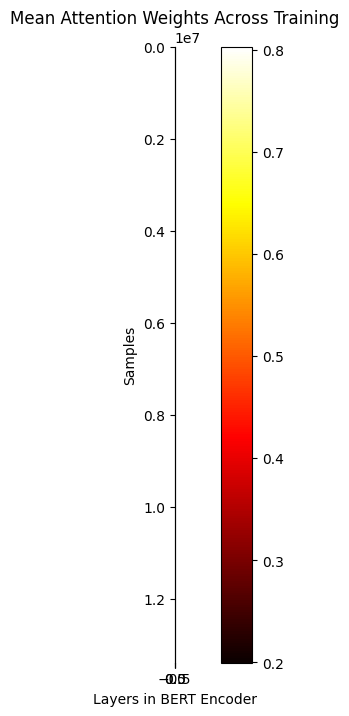

In [28]:
import numpy as np

# Calculate the number of layers for each sample
num_samples = len(attention_weight_changes1)
num_layers_per_sample = num_samples // len(attention_weight_changes1)

# Reshape attention_weight_changes1 for plotting
attention_weight_changes_reshaped = np.reshape(attention_weight_changes1, (len(attention_weight_changes1), num_layers_per_sample))

# Plot attention weight changes
plt.figure(figsize=(12, 8))
plt.imshow(attention_weight_changes_reshaped, cmap='hot', interpolation='nearest')
plt.title('Mean Attention Weights Across Training')
plt.xlabel('Layers in BERT Encoder')
plt.ylabel('Samples')
plt.colorbar()
plt.show()


In [29]:
# Function to plot attention weights for a given input text
def plot_attention_weights(input_text):
    # Tokenize input text
    input_ids = tokenizer.encode(input_text, return_tensors='pt', max_length=tokenizer.model_max_length, truncation=True)
    input_ids = input_ids.to(device)

    # Perform forward pass to get attention weights
    classifier.eval()
    with torch.no_grad():
        _, attention_weights = classifier(input_ids, attention_mask=None, token_type_ids=None)

    # Extract attention weights and input tokens
    attention_weights = attention_weights.squeeze(0).cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().cpu().numpy())

    # Plot attention weights
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(tokens)), attention_weights, tick_label=tokens)
    plt.xticks(rotation=90)
    plt.xlabel('Tokens')
    plt.ylabel('Attention Weights')
    plt.title('Attention Weights for Input Text')
    plt.show()

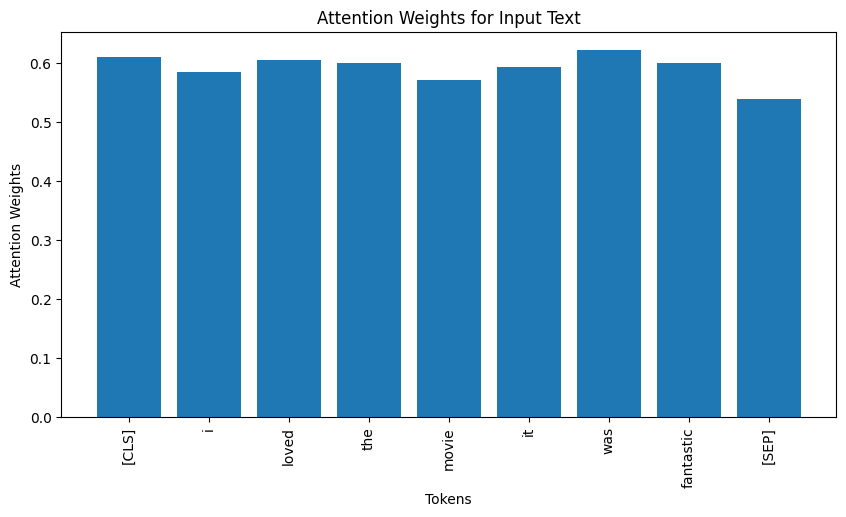

In [32]:
# Example input text
input_text = "I loved the movie it was fantastic"

# Plot attention weights for the example input text
plot_attention_weights(input_text)

In [34]:
# Sample input text
input_text = "I loved the movie it was fantastic"

# Tokenize the input text
encoded_input = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
input_ids = encoded_input['input_ids'].to(device)
attention_mask = encoded_input['attention_mask'].to(device)
token_type_ids = encoded_input['token_type_ids'].to(device)

In [35]:
logits, attention_weights = classifier(input_ids, attention_mask, token_type_ids)
probabilities = torch.softmax(logits, dim=1)
decoded_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())


In [37]:
# Print the output
print("Input Text:", input_text)
print("Predicted Probabilities:", probabilities)
print("Attention Weights:", attention_weights)
print("Decoded Tokens:", decoded_tokens)

Input Text: I loved the movie it was fantastic
Predicted Probabilities: tensor([[4.4644e-04, 9.9955e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Attention Weights: tensor([[0.6108, 0.5847, 0.6055, 0.6009, 0.5724, 0.5945, 0.6219, 0.6004, 0.5392]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
Decoded Tokens: ['[CLS]', 'i', 'loved', 'the', 'movie', 'it', 'was', 'fantastic', '[SEP]']


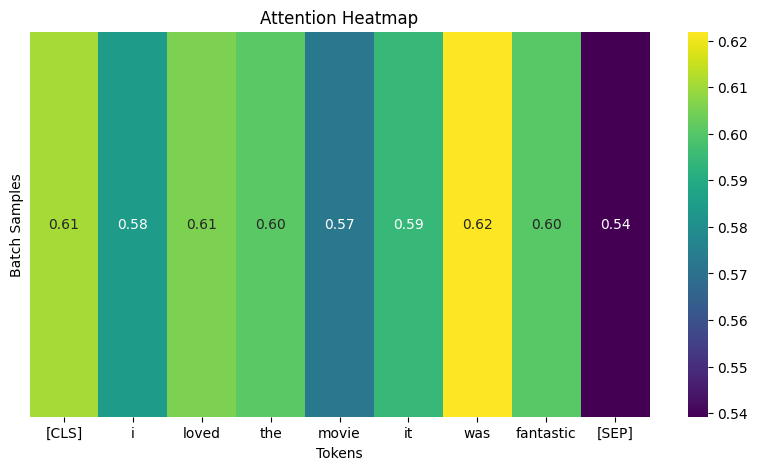

In [38]:

import seaborn as sns

# Convert attention weights to numpy array
attention_weights_np = attention_weights.detach().cpu().numpy()

# Plot heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(attention_weights_np, cmap='viridis', annot=True, fmt=".2f", xticklabels=decoded_tokens, yticklabels=False)
plt.title("Attention Heatmap")
plt.xlabel("Tokens")
plt.ylabel("Batch Samples")
plt.show()
